## Anomaly Detection for NYC Taxi & Limousine Data

In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
from geopandas import GeoDataFrame
import os
import subprocess
from shapely.geometry import Point
from datetime import datetime
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score as rs
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import IsolationForest

from itertools import compress

np.random.seed(222)

%matplotlib inline
%pylab inline
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120

Populating the interactive namespace from numpy and matplotlib


/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
`%matplotlib` prevents importing * from pylab and numpy


In [2]:
proj_folder = os.getcwd()

## TLC anomaly detection

## Notes 4-22-17
Next steps:
1. would love to look at different areas of the city and see where the anomalies relative to those places
i.e. taxi trips to/from coney island would be interesting / or around MSG - "concert superstorm?"

## Notes 4-26-17
Next steps:
1. add day of week analysis 
2. add more months of data

In [3]:
### read in data for 2016
'''
taken from
http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml
NOTE: after june 2016, the data no longer has lat / lons, only has neighborhoods
'''

columns = ['passenger_count', 'trip_distance', 'fare_amount', \
                     'extra', 'mta_tax', 'tip_amount', 'total_amount', \
                     'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude',\
                     'pickup_latitude']
tlc_df_raw_total = pd.DataFrame(columns = columns)
for i in range(1,7):
    print i
    tlc_df_raw = pd.read_csv(proj_folder + '/data/tlc_yellow_2016_0' + str(i) + '.csv', usecols=['passenger_count', \
                    'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'total_amount', \
                     'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude', 'pickup_latitude'])
    tlc_df_raw_total = tlc_df_raw_total.append(tlc_df_raw, ignore_index=True)
'''
for i in range(10,13):
    print i
    tlc_df_raw = pd.read_csv(proj_folder + '/data/tlc_yellow_2016_' + str(i) + '.csv', usecols=['passenger_count', \
                    'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'total_amount', \
                     'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude', 'pickup_latitude'])
    tlc_df_raw_total = tlc_df_raw_total.append(tlc_df_raw, ignore_index=True)
'''

1
2
3
4
5
6


"\nfor i in range(10,13):\n    print i\n    tlc_df_raw = pd.read_csv(proj_folder + '/data/tlc_yellow_2016_' + str(i) + '.csv', usecols=['passenger_count',                     'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'total_amount',                      'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude', 'pickup_latitude'])\n    tlc_df_raw_total = tlc_df_raw_total.append(tlc_df_raw, ignore_index=True)\n"

In [4]:
len(tlc_df_raw_total)

69406520

In [5]:
tlc_df_raw_total['tpep_pickup_datetime'] = pd.to_datetime(tlc_df_raw_total['tpep_pickup_datetime'])
tlc_df_raw_total['tpep_dropoff_datetime'] = pd.to_datetime(tlc_df_raw_total['tpep_dropoff_datetime'])
tlc_df_raw_total.head()

,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance
0,0.5,7.5,0.5,2.0,40.734695,-73.990372,0.0,8.8,2016-01-01,2016-01-01,1.10
1,0.5,18.0,0.5,5.0,40.729912,-73.980782,0.0,19.3,2016-01-01,2016-01-01,4.90
2,0.5,33.0,0.5,1.0,40.679565,-73.984550,0.0,34.3,2016-01-01,2016-01-01,10.54
3,0.0,16.5,0.5,1.0,40.718990,-73.993469,0.0,17.3,2016-01-01,2016-01-01,4.75
4,0.0,8.0,0.5,3.0,40.781330,-73.960625,0.0,8.8,2016-01-01,2016-01-01,1.76


In [6]:
#CANNOT GET THIS TRIP DURATION TO WORK - MOVING ON FOR NOW
#tlc_df['trip_duration'] = pd.Timedelta(tlc_df['tpep_dropoff_datetime_2'] - tlc_df['tpep_pickup_datetime']).seconds / 3600.0
#tlc_df['trip_speed'] = tlc_df.trip_distance / tlc_df.trip_duration

## Clean the data - 
drop all the unreasonable trip entries, such as those that have trip distance in the millions of miles

In [7]:
#tlc_df_raw_total.sort(['trip_distance'], ascending=False).head()

In [8]:
#tlc_df_raw_total.sort(['total_amount'], ascending=False).head()

In [9]:
#tlc_df_raw_total.sort(['tip_amount'], ascending=False).head()

In [10]:
#only keep trips that have a positive distance less than 100 miles
tlc_df_total = tlc_df_raw_total[(tlc_df_raw_total.trip_distance > 0) & (tlc_df_raw_total.trip_distance < 100)]

#only keep trips that have a positive fare amount less than $500
tlc_df_total = tlc_df_total[(tlc_df_total.fare_amount > 0) & (tlc_df_total.fare_amount < 500)]

In [11]:
len(tlc_df_total) * 1.0 / len(tlc_df_raw_total)

0.9933886038372187

In [12]:
#count the number of taxi trips each day
tlc_df_total['taxi_date'] = tlc_df_total['tpep_pickup_datetime'].dt.date
tlc_df_day_count = tlc_df_total.groupby(['taxi_date'], as_index=False)['extra'].count()
tlc_df_day_count.columns = ['taxi_date', 'taxi_trip_count']

In [13]:
#take the mean of the taxi stats each day
tlc_df_stat_agg = tlc_df_total.groupby(['taxi_date'], as_index=False).mean()
tlc_df_stat_agg.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance
0,2016-01-01,0.270617,12.795289,0.498092,1.795093,40.177206,-72.933026,1.441512,15.569496,3.292646
1,2016-01-02,0.198105,12.392116,0.498403,1.777977,40.093708,-72.781330,1.459314,15.139841,3.082059
2,2016-01-03,0.200098,12.997669,0.498177,1.739239,40.135610,-72.855615,1.650988,16.022176,3.425719
3,2016-01-04,0.374877,12.159065,0.498728,1.649450,40.075239,-72.740969,1.634711,15.314045,3.031284
4,2016-01-05,0.356747,11.954732,0.498906,1.635951,40.023580,-72.647829,1.649986,15.040607,2.830233


In [14]:
tlc_df_by_day = tlc_df_stat_agg.merge(tlc_df_day_count, on='taxi_date')
tlc_df_by_day.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,taxi_trip_count
0,2016-01-01,0.270617,12.795289,0.498092,1.795093,40.177206,-72.933026,1.441512,15.569496,3.292646,342467
1,2016-01-02,0.198105,12.392116,0.498403,1.777977,40.093708,-72.781330,1.459314,15.139841,3.082059,310850
2,2016-01-03,0.200098,12.997669,0.498177,1.739239,40.135610,-72.855615,1.650988,16.022176,3.425719,300678
3,2016-01-04,0.374877,12.159065,0.498728,1.649450,40.075239,-72.740969,1.634711,15.314045,3.031284,314058
4,2016-01-05,0.356747,11.954732,0.498906,1.635951,40.023580,-72.647829,1.649986,15.040607,2.830233,341089


In [15]:
tlc_df_by_day['weekday'] = 0
for i in range(len(tlc_df_by_day)):
    tlc_df_by_day['weekday'].iloc[i] = tlc_df_by_day.taxi_date.iloc[i].weekday()

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


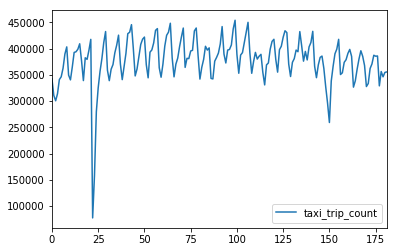

In [16]:
tlc_df_by_day[['taxi_date', 'taxi_trip_count']].plot()

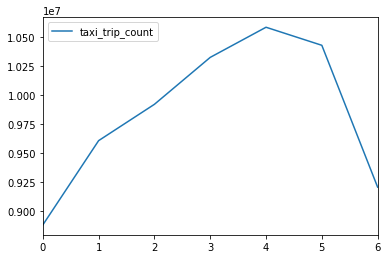

In [17]:
tlc_df_by_day_agg = tlc_df_by_day.groupby(['weekday'], as_index=False).sum()
tlc_df_by_day_agg[['taxi_trip_count']].plot()

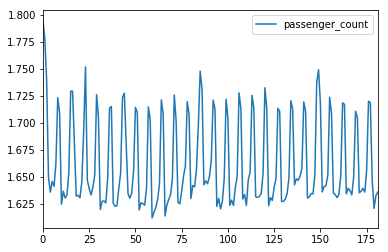

In [18]:
tlc_df_by_day[['taxi_date', 'passenger_count']].plot()

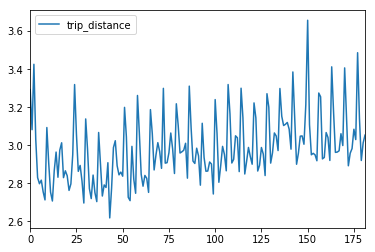

In [19]:
tlc_df_by_day[['taxi_date', 'trip_distance']].plot()

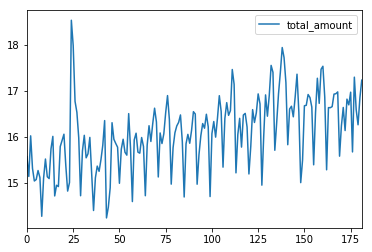

In [20]:
tlc_df_by_day[['taxi_date', 'total_amount']].plot()

In [21]:
X = tlc_df_by_day[['passenger_count', 'trip_distance' ,'total_amount', 'taxi_trip_count']]
X.head(2)

,passenger_count,trip_distance,total_amount,taxi_trip_count
0,1.795093,3.292646,15.569496,342467
1,1.777977,3.082059,15.139841,310850


## Clustering Anomaly Detection

### Gaussian Mixture Model Anomaly Detection

In [22]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.544207992527
For n_clusters =3, the average silhouette_score is :0.550538266279
For n_clusters =4, the average silhouette_score is :0.543537511976
For n_clusters =5, the average silhouette_score is :0.558885807843
For n_clusters =6, the average silhouette_score is :0.560226490581
For n_clusters =7, the average silhouette_score is :0.550931472344
For n_clusters =8, the average silhouette_score is :0.545324387618


In [23]:
GM=GaussianMixture(n_components=2, random_state=324)
GM.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=324, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

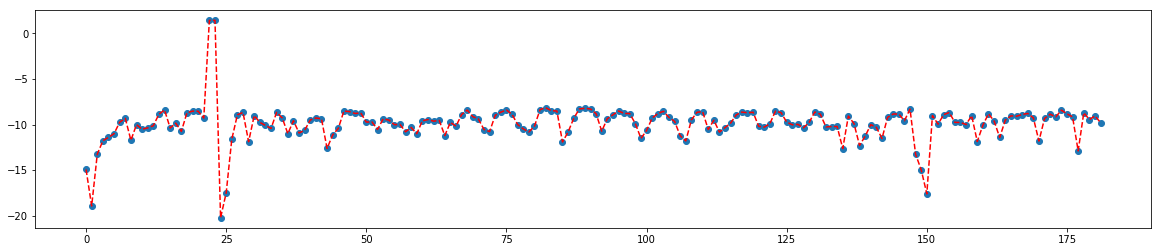

In [24]:
%matplotlib inline
import matplotlib.pylab as plt
plt.figure(figsize=(20,4))
plt.scatter(range(len(X)),GM.score_samples(X))
plt.plot(GM.score_samples(X),"r--")
plt.show()

## Isolation Anomaly Detection

### Isolation Forest Anomaly Detection

In [25]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [26]:
tlc_df_by_day['decision_function'] = clf.decision_function(X)

In [27]:
tlc_df_by_day.sort_values(by='decision_function').head(10)

,taxi_date,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,taxi_trip_count,weekday,decision_function
22,2016-01-23,0.362535,11.875412,0.498546,1.691393,40.156820,-72.907324,1.680846,14.821589,2.797509,77354,5,-0.150264
150,2016-05-30,0.183829,13.517057,0.498000,1.717996,40.297975,-73.150372,1.731856,16.675892,3.657138,259248,0,-0.110895
23,2016-01-24,0.149384,12.179742,0.498538,1.751895,40.245866,-73.052736,1.624971,15.007358,2.951654,158675,6,-0.102197
2,2016-01-03,0.200098,12.997669,0.498177,1.739239,40.135610,-72.855615,1.650988,16.022176,3.425719,300678,6,-0.071914
177,2016-06-26,0.216860,14.059917,0.497735,1.718709,40.297044,-73.152547,1.821446,17.297069,3.486542,329107,6,-0.067998
24,2016-01-25,0.379404,14.854335,0.498136,1.647179,40.242313,-73.045338,2.086684,18.534021,3.319237,279805,0,-0.065968
43,2016-02-13,0.198109,11.556715,0.498945,1.723480,39.963539,-72.549819,1.513157,14.238487,2.618400,445761,5,-0.061721
1,2016-01-02,0.198105,12.392116,0.498403,1.777977,40.093708,-72.781330,1.459314,15.139841,3.082059,310850,5,-0.059943
149,2016-05-29,0.200798,12.751599,0.498280,1.749360,40.297822,-73.156586,1.467189,15.495870,3.213553,296246,6,-0.049930
0,2016-01-01,0.270617,12.795289,0.498092,1.795093,40.177206,-72.933026,1.441512,15.569496,3.292646,342467,4,-0.048510


## Look at specific areas and see what times / dates around there are anomalies
### Madison Square Gardens (40.750556, -73.993611)

In [28]:
latlon_list = [40.750556, -73.993611]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
tlc_df_total_subset = tlc_df_total[(tlc_df_total.pickup_latitude > (latlon_list[0] - 0.005)) & (tlc_df_total.pickup_latitude < (latlon_list[0] + 0.005))]
tlc_df_total_subset = tlc_df_total_subset[(tlc_df_total_subset.pickup_longitude > (latlon_list[1] - 0.005)) & (tlc_df_total_subset.pickup_longitude < (latlon_list[1] + 0.005))]

In [29]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(tlc_df_total_subset.pickup_longitude, tlc_df_total_subset.pickup_latitude)]

In [30]:
crs = {'init': 'epsg:4326'}
tlc_df_total_gp = GeoDataFrame(tlc_df_total_subset, crs=crs, geometry=geometry)

In [31]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [32]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

,geometry
0,"POLYGON ((-73.98861100000001 40.750556, -73.98..."


In [33]:
# only keep points within MSG buffer
tlc_df_total_gp_subset = tlc_df_total_gp[tlc_df_total_gp.geometry.intersects(MSG_gp.geometry[0])]

In [34]:
tlc_df_total_gp_subset.head()

,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,taxi_date,geometry
22,0.5,5.0,0.5,1.0,40.747219,-73.997139,0.00,6.30,2016-01-01 00:04:37,2016-01-01 00:00:08,0.72,2016-01-01,POINT (-73.99713897705078 40.74721908569336)
28,0.5,3.0,0.5,1.0,40.754559,-73.991653,0.00,4.30,2016-01-01 00:01:17,2016-01-01 00:00:12,0.13,2016-01-01,POINT (-73.99165344238281 40.75455856323241)
57,0.5,7.0,0.5,6.0,40.751621,-73.993759,0.00,8.30,2016-01-01 00:09:37,2016-01-01 00:00:32,0.32,2016-01-01,POINT (-73.99375915527344 40.75162124633789)
108,0.0,140.0,0.0,1.0,40.749290,-73.992302,30.95,185.75,2016-01-01 00:38:19,2016-01-01 00:01:14,24.00,2016-01-01,POINT (-73.99230194091797 40.74929046630859)
192,0.0,7.5,0.5,1.0,40.749737,-73.991203,0.00,8.30,2016-01-29 09:28:43,2016-01-29 09:18:22,0.80,2016-01-29,POINT (-73.99120330810547 40.74973678588867)


In [35]:
tlc_df_total_gp_subset['hour'] = tlc_df_total_gp_subset.tpep_pickup_datetime.apply(lambda x: x.hour)

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [36]:
#subset to 3pm - midnight hours (to only capture relevant hours)
tlc_df_total_gp_subset = tlc_df_total_gp_subset[(tlc_df_total_gp_subset.hour >= 15) & (tlc_df_total_gp_subset.hour <= 23)]

In [37]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_count = tlc_df_total_gp_subset.groupby(['taxi_date', 'hour'], as_index=False)['extra'].count()
tlc_df_MSG_count.columns = ['taxi_date', 'hour', 'taxi_trip_count']
tlc_df_MSG_count.head()

,taxi_date,hour,taxi_trip_count
0,2016-01-01,15,632
1,2016-01-01,16,658
2,2016-01-01,17,700
3,2016-01-01,18,778
4,2016-01-01,19,654


In [38]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_mean = tlc_df_total_gp_subset.groupby(['taxi_date', 'hour'], as_index=False).mean()
tlc_df_MSG_mean.head()

,taxi_date,hour,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance
0,2016-01-01,15,0.006329,11.197785,0.497627,1.677215,40.750490,-73.992650,0.996899,13.291551,2.691519
1,2016-01-01,16,0.083587,10.381459,0.498480,1.791793,40.750509,-73.992717,1.049195,12.501292,2.378754
2,2016-01-01,17,0.097143,10.455714,0.498571,1.712857,40.750433,-73.992623,1.172400,12.681371,2.351357
3,2016-01-01,18,0.094473,10.737789,0.498715,1.780206,40.750437,-73.992632,1.108458,12.844216,2.321941
4,2016-01-01,19,0.120031,11.607798,0.500000,1.782875,40.750327,-73.992521,1.246407,13.943654,2.517890


In [39]:
tlc_df_MSG_by_day_hour = tlc_df_MSG_count.merge(tlc_df_MSG_mean, on=['taxi_date', 'hour'])
tlc_df_MSG_by_day_hour.head()

,taxi_date,hour,taxi_trip_count,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance
0,2016-01-01,15,632,0.006329,11.197785,0.497627,1.677215,40.750490,-73.992650,0.996899,13.291551,2.691519
1,2016-01-01,16,658,0.083587,10.381459,0.498480,1.791793,40.750509,-73.992717,1.049195,12.501292,2.378754
2,2016-01-01,17,700,0.097143,10.455714,0.498571,1.712857,40.750433,-73.992623,1.172400,12.681371,2.351357
3,2016-01-01,18,778,0.094473,10.737789,0.498715,1.780206,40.750437,-73.992632,1.108458,12.844216,2.321941
4,2016-01-01,19,654,0.120031,11.607798,0.500000,1.782875,40.750327,-73.992521,1.246407,13.943654,2.517890


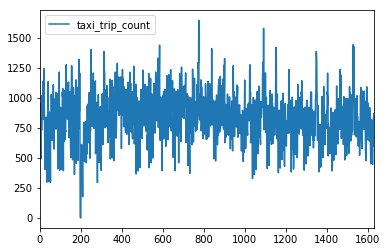

In [40]:
tlc_df_MSG_by_day_hour[['taxi_date', 'taxi_trip_count']].plot()

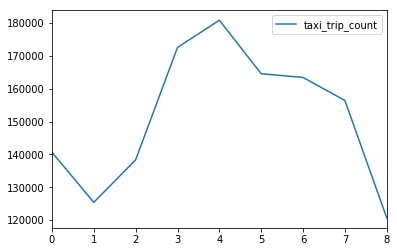

In [41]:
tlc_agg = tlc_df_MSG_by_day_hour.groupby(['hour'], as_index=False).sum()
tlc_agg[['taxi_trip_count']].plot()

In [42]:
# read in NYC street shapefile
'''
shapefile taken from https://geo.nyu.edu/catalog/nyu_2451_34565

'''
ny_streets_raw = gp.read_file(proj_folder + '/data/nyu_2451_34565/nyu_2451_34565.shp')
ny_streets_raw = ny_streets_raw.to_crs(epsg=4326)
# only keep points within MSG buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

In [43]:
tlc_df_total_gp_subset['total_mean'] = tlc_df_total_gp_subset.total_amount.mean()
tlc_df_total_gp_subset['total_std'] = tlc_df_total_gp_subset.total_amount.std()

def set_color(Data1):
    if (Data1.total_amount > (Data1.total_mean + 2*Data1.total_std)):
        return "green"
    elif (Data1.total_amount < (Data1.total_mean - 2*Data1.total_std)):
        return "red"
    else:
        return "white"

    
tlc_df_total_gp_subset = tlc_df_total_gp_subset.assign(color=tlc_df_total_gp_subset.apply(set_color, axis=1))
tlc_df_total_gp_subset = tlc_df_total_gp_subset.drop(['total_mean', 'total_std'], axis=1)

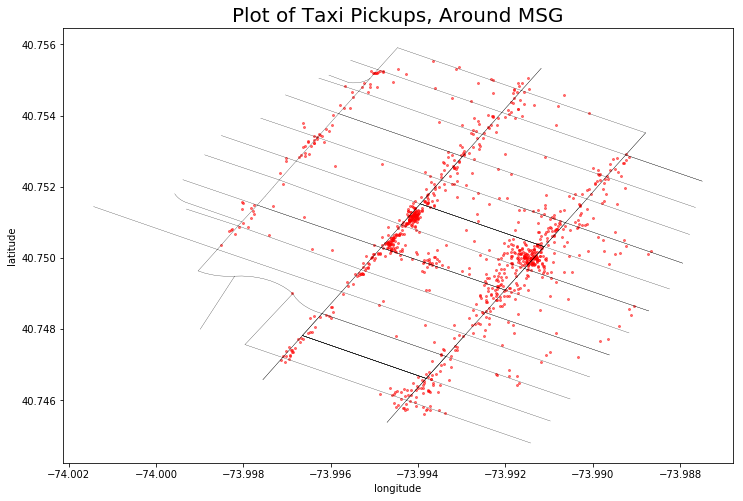

In [44]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = tlc_df_total_gp_subset.sample(n=1000)
#MSG_sample.lon = MSG_sample.geometry.x
#MSG_sample.lat = MSG_sample.geometry.y
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of Taxi Pickups, Around MSG", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## MSG anomaly analysis (isolation forest)

In [45]:
X = tlc_df_MSG_by_day_hour[['passenger_count', 'trip_distance' ,'total_amount', 'taxi_trip_count']]
X.head(2)

,passenger_count,trip_distance,total_amount,taxi_trip_count
0,1.677215,2.691519,13.291551,632
1,1.791793,2.378754,12.501292,658


In [46]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [47]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [48]:
tlc_df_MSG_by_day_hour['decision_function'] = clf.decision_function(X)

In [49]:
tlc_df_MSG_by_day_hour.sort_values(by='decision_function').head(10)

,taxi_date,hour,taxi_trip_count,extra,fare_amount,mta_tax,passenger_count,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,decision_function
200,2016-01-23,17,1,0.000000,76.500000,0.500000,1.000000,40.750286,-73.992531,0.000000,82.840000,21.500000,-0.191391
1238,2016-05-18,16,408,1.127451,19.803922,0.490196,1.551471,40.750321,-73.993102,2.637353,25.165196,3.430760,-0.137369
210,2016-01-24,23,177,0.494350,12.932203,0.497175,1.898305,40.750102,-73.993395,1.665028,16.147175,3.272373,-0.137026
1590,2016-06-26,17,496,0.040323,21.219758,0.493952,1.750000,40.750680,-73.992823,2.443952,24.966915,3.380645,-0.135195
1589,2016-06-26,16,568,0.022887,18.330106,0.494718,1.732394,40.750471,-73.992944,2.218732,21.947623,3.330599,-0.126717
480,2016-02-23,23,393,0.498728,13.279898,0.498728,1.440204,40.750317,-73.993007,1.903461,16.632774,3.393359,-0.113576
201,2016-01-23,18,1,0.000000,10.500000,0.500000,1.000000,40.747868,-73.996651,2.250000,13.550000,2.100000,-0.105518
198,2016-01-23,15,15,0.000000,10.133333,0.500000,1.200000,40.750917,-73.992586,1.584000,12.517333,2.375333,-0.104815
1427,2016-06-08,16,425,1.045882,17.232941,0.498824,1.571765,40.750544,-73.993197,2.237788,21.646329,2.569482,-0.100603
1591,2016-06-26,18,477,0.031447,19.361635,0.498952,1.721174,40.750531,-73.993133,2.152390,22.690776,2.945199,-0.096394


## Look at specific areas and see what times / dates around there are anomalies
### staten island ferry terminal (Whitehall between state & FDR) (40.702095, -74.012782)

In [50]:
latlon_list = [40.702095, -74.012782]
#only keep trips within a reasonable pickup lat / lon (without converting geometries)
tlc_df_total_subset = tlc_df_total[(tlc_df_total.pickup_latitude > (latlon_list[0] - 0.005)) & (tlc_df_total.pickup_latitude < (latlon_list[0] + 0.005))]
tlc_df_total_subset = tlc_df_total_subset[(tlc_df_total_subset.pickup_longitude > (latlon_list[1] - 0.005)) & (tlc_df_total_subset.pickup_longitude < (latlon_list[1] + 0.005))]

In [51]:
len(tlc_df_total_subset)

558160

In [52]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(tlc_df_total_subset.pickup_longitude, tlc_df_total_subset.pickup_latitude)]
tlc_df_total_subset = tlc_df_total_subset.drop(['pickup_latitude', 'pickup_longitude'], axis=1)

In [53]:
crs = {'init': 'epsg:4326'}
tlc_df_total_gp = GeoDataFrame(tlc_df_total_subset, crs=crs, geometry=geometry)

In [54]:
# create MSG buffer 
d = {'latitude': latlon_list[0], 'longitude': latlon_list[1]}
MSG = pd.DataFrame(data=d, index=[0])
geometry_MSG = [Point(xy) for xy in zip(MSG.longitude, MSG.latitude)]
crs = {'init': 'epsg:4326'}
MSG_gp = GeoDataFrame(crs=crs, geometry=geometry_MSG)

In [55]:
#create buffer
MSG_gp['geometry'] = MSG_gp.geometry.buffer(.005)
MSG_gp.head()

,geometry
0,"POLYGON ((-74.00778200000001 40.702095, -74.00..."


In [56]:
# only keep points within MSG buffer
tlc_df_total_gp_subset = tlc_df_total_gp[tlc_df_total_gp.geometry.intersects(MSG_gp.geometry[0])]

In [57]:
tlc_df_total_gp_subset['hour'] = tlc_df_total_gp_subset.tpep_pickup_datetime.apply(lambda x: x.hour)

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [58]:
#subset to 6am or greater hours (to only capture relevant hours)
tlc_df_total_gp_subset = tlc_df_total_gp_subset[(tlc_df_total_gp_subset.hour >= 6)]

In [59]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_count = tlc_df_total_gp_subset.groupby(['taxi_date', 'hour'], as_index=False)['extra'].count()
tlc_df_MSG_count.columns = ['taxi_date', 'hour', 'taxi_trip_count']
tlc_df_MSG_count.head()

,taxi_date,hour,taxi_trip_count
0,2016-01-01,6,14
1,2016-01-01,7,15
2,2016-01-01,8,27
3,2016-01-01,9,37
4,2016-01-01,10,53


In [60]:
#take the mean of the taxi stats each day / hour
tlc_df_MSG_mean = tlc_df_total_gp_subset.groupby(['taxi_date', 'hour'], as_index=False).mean()
tlc_df_MSG_mean.head()

,taxi_date,hour,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance
0,2016-01-01,6,0.0,22.821429,0.464286,2.285714,2.372143,27.200714,6.947143
1,2016-01-01,7,0.0,20.500000,0.500000,1.266667,1.640667,22.940667,6.773333
2,2016-01-01,8,0.0,19.666667,0.481481,1.925926,1.843333,22.701852,5.560370
3,2016-01-01,9,0.0,13.864865,0.500000,1.945946,0.904324,15.569189,4.062973
4,2016-01-01,10,0.0,16.216981,0.490566,1.698113,1.374906,18.580566,4.759245


In [61]:
tlc_df_MSG_by_day_hour = tlc_df_MSG_count.merge(tlc_df_MSG_mean, on=['taxi_date', 'hour'])
tlc_df_MSG_by_day_hour.head()

,taxi_date,hour,taxi_trip_count,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance
0,2016-01-01,6,14,0.0,22.821429,0.464286,2.285714,2.372143,27.200714,6.947143
1,2016-01-01,7,15,0.0,20.500000,0.500000,1.266667,1.640667,22.940667,6.773333
2,2016-01-01,8,27,0.0,19.666667,0.481481,1.925926,1.843333,22.701852,5.560370
3,2016-01-01,9,37,0.0,13.864865,0.500000,1.945946,0.904324,15.569189,4.062973
4,2016-01-01,10,53,0.0,16.216981,0.490566,1.698113,1.374906,18.580566,4.759245


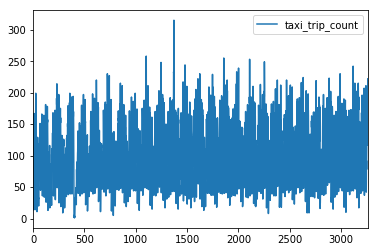

In [62]:
tlc_df_MSG_by_day_hour[['taxi_date', 'taxi_trip_count']].plot()

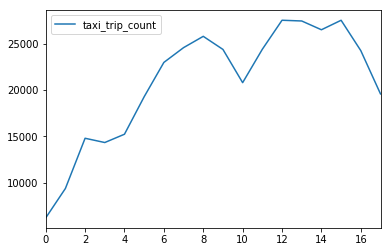

In [63]:
tlc_agg = tlc_df_MSG_by_day_hour.groupby(['hour'], as_index=False).sum()
tlc_agg[['taxi_trip_count']].plot()

In [64]:

# only keep points within buffer
ny_streets = ny_streets_raw[ny_streets_raw.geometry.intersects(MSG_gp.geometry[0])]

In [65]:
tlc_df_total_gp_subset['total_mean'] = tlc_df_total_gp_subset.total_amount.mean()
tlc_df_total_gp_subset['total_std'] = tlc_df_total_gp_subset.total_amount.std()

def set_color(Data1):
    if (Data1.total_amount > (Data1.total_mean + 2*Data1.total_std)):
        return "green"
    elif (Data1.total_amount < (Data1.total_mean - 2*Data1.total_std)):
        return "red"
    else:
        return "white"

    
tlc_df_total_gp_subset = tlc_df_total_gp_subset.assign(color=tlc_df_total_gp_subset.apply(set_color, axis=1))
tlc_df_total_gp_subset = tlc_df_total_gp_subset.drop(['total_mean', 'total_std'], axis=1)

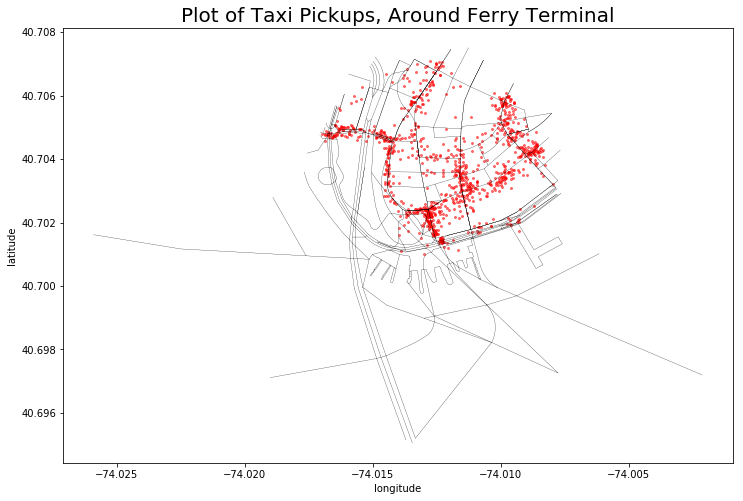

In [66]:
# is there a way to easily plot each color differently? I have this color column highlighting outliers!

MSG_sample = tlc_df_total_gp_subset.sample(n=1000)
#MSG_sample.lon = MSG_sample.geometry.x
#MSG_sample.lat = MSG_sample.geometry.y
f, (ax1) = plt.subplots(figsize=(12,8))
MSG_sample.plot(alpha=0.5, ax=ax1, color = 'red')
ny_streets['geometry'].plot(alpha=1, linewidth=0.25, ax=ax1, color = '0')
ax1.set_title("Plot of Taxi Pickups, Around Ferry Terminal", fontsize=20)
plt.xlabel("longitude")
plt.ylabel("latitude")

## Ferry Terminal anomaly analysis (isolation forest)

In [67]:
X = tlc_df_MSG_by_day_hour[['passenger_count', 'trip_distance' ,'total_amount', 'taxi_trip_count']]
X.head(2)

,passenger_count,trip_distance,total_amount,taxi_trip_count
0,2.285714,6.947143,27.200714,14
1,1.266667,6.773333,22.940667,15


In [68]:
#normalize columns
for i in X.columns:
    X[i] = (X[i] - X[i].mean()) / X[i].std()

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [69]:
train,test=train_test_split(X, random_state=999, test_size=0.3)
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(train)
y_pred = clf.predict(X)

In [70]:
tlc_df_MSG_by_day_hour['decision_function'] = clf.decision_function(X)

In [72]:
tlc_df_MSG_by_day_hour.sort_values(by='decision_function').head(10)

,taxi_date,hour,taxi_trip_count,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance,decision_function
397,2016-01-23,7,4,0.00000,10.625000,0.500000,1.000000,0.987500,12.412500,2.340000,-0.139265
402,2016-01-23,12,1,0.00000,3.000000,0.500000,1.000000,0.000000,3.800000,0.100000,-0.139265
306,2016-01-18,6,17,0.00000,22.235294,0.470588,1.235294,3.623529,27.364706,7.004118,-0.138438
0,2016-01-01,6,14,0.00000,22.821429,0.464286,2.285714,2.372143,27.200714,6.947143,-0.136899
2797,2016-06-05,6,16,0.00000,26.312500,0.500000,1.500000,2.459375,30.228125,8.670000,-0.131270
405,2016-01-24,8,4,0.00000,7.625000,0.500000,2.250000,1.505000,9.930000,1.660000,-0.129970
2689,2016-05-30,6,9,0.00000,26.277778,0.444444,1.777778,3.015556,32.042222,8.303333,-0.127216
3049,2016-06-19,6,10,0.00000,24.950000,0.500000,1.800000,4.242000,30.546000,8.764000,-0.124242
2923,2016-06-12,6,21,0.02381,24.214286,0.476190,1.857143,2.515714,29.059524,7.971905,-0.119196
1,2016-01-01,7,15,0.00000,20.500000,0.500000,1.266667,1.640667,22.940667,6.773333,-0.116386
